# Consumer Buying Behavior

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.preprocessing import PowerTransformer

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Functions

In [49]:

def spot_check_models(X,y):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
    X: Pd.Dataframe
    y: Pd.Series

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }
    
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X,y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    for i in range(len(models)):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
        # Evaluate the model
        scores = evaluate_model(X, y, pipeline)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

def test_predictions(X,y, names, models):
    """_summary_

    Args:
        X (_type_): _description_
        y (_type_): _description_
        names (_type_): _description_
        model (_type_): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ("power_tranformer",PowerTransformer()), 
            ("model", model)
            ])
        
        pipeline.fit(X_train, y_train)
        # Predict on the test set
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Test Accuracy": accuracy,
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('model', model)
        ])
            
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', LogisticRegression(class_weight='balanced', penalty='l2'))
    ])
    
    param_grid = {
        'model__solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'model__C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', SVC())
    ])
    
    param_grid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search




# EDA Analysis

In [3]:
df = pd.read_csv("social_ads.csv")
df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


# Check For Dupes

In [4]:
print(f"The amount of null values: {df.isna().sum()}")
print(f"The amount of Duplicates: {df.duplicated().sum()}")

The amount of null values: Age                0
EstimatedSalary    0
Purchased          0
dtype: int64
The amount of Duplicates: 33


# Drop Dupes

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(367, 3)

# Check for Target class Balances

In [9]:
target = df.values[:,-1]

counter = Counter(target)

for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k,v, per))

Class=0, Count=229, Percentage=62.398%
Class=1, Count=138, Percentage=37.602%


# Fairly blanced set of data

In [10]:
df.describe()

,Age,EstimatedSalary,Purchased
count,367.000000,367.000000,367.000000
mean,37.722071,70719.346049,0.376022
std,10.681383,34772.173908,0.485047
min,18.000000,15000.000000,0.000000
25%,29.500000,43000.000000,0.000000
50%,37.000000,71000.000000,0.000000
75%,46.000000,89000.000000,1.000000
max,60.000000,150000.000000,1.000000


# Calculate Entropy

In [11]:
calculate_entropy(df)

,Age,EstimatedSalary,Purchased
entropy,5.208731,6.611593,0.955184


# Visuals

<Axes: >

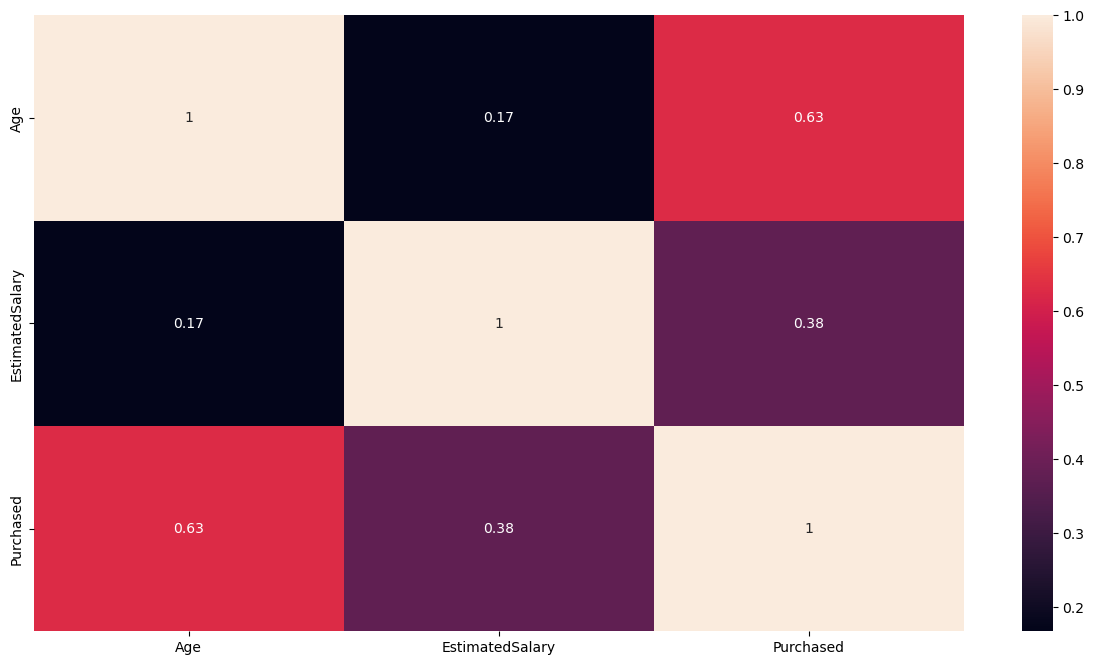

In [12]:
relations = df.corr()
plt.figure(figsize=(15,8))

sns.heatmap(data=relations, annot=True)

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

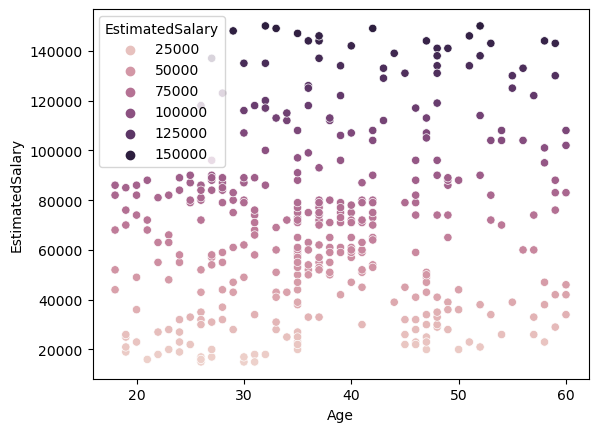

In [15]:
sns.scatterplot(data=df, x="Age", y ="EstimatedSalary", hue="EstimatedSalary")

# Split Feature Labels

In [17]:
X,y = df.drop("Purchased", axis=1), df["Purchased"]

# Baseline Model Evaluation

In [18]:

model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X,y, model)
print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.526 (0.077)


# 52% is the baseline model we should outperform.

# Spot Check Algorithms

In [19]:
spot_check_models(X, y)

2024-04-20 17:24:50.849304: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 0s 662us/step - loss: 0.3019 - accuracy: 0.9099


,Model,Accuracy
10,Sequential,0.909910
2,GPC,0.900901
4,SVC,0.900901
5,KNeighborsClassifier,0.873874
8,GradientBoostingClassifier,0.873874
9,XGB,0.873874
0,GaussianNB,0.855856
7,RandomForestClassifier,0.846847
3,LogisticRegression,0.828829
1,LDA,0.819820


# Advanced Model spot checking

In [21]:
names = ["GPC", "SVC", "LR", "LDA", "KNN", "GNB", "DTC", "RFC", "XGB", "GBC"]
models = get_selected_models(names)

testing_selected_models(names, models, X, y)

>GPC 0.895 (0.057)
>SVC 0.898 (0.059)
>LR 0.826 (0.063)
>LDA 0.831 (0.059)
>KNN 0.887 (0.050)
>GNB 0.884 (0.060)
>DTC 0.842 (0.061)
>RFC 0.879 (0.054)
>XGB 0.872 (0.056)
>GBC 0.880 (0.055)


# Best performing Models are 
1. SVC
2. GPC
3. RFC
4. KNN
5. GBC
6. GNB

# MLP Tuning

In [29]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1

def create_keras_classifier(function, optimizer, idx, param):
    if idx == 0:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=100, 
            batch_size=64, 
            verbose=0
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2
]
# Define the optimizers to iterate over
optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2"]
values = [1e-1, 1e-2, 1e-3, 1e-4]
model_performance = []
for index, function in enumerate(functions):
    name = function_names[index]
    for idx, optimizer in enumerate(optimizers):
        optimizer_name = optimizer_names[idx]
        value = values[idx]
        model = create_keras_classifier(function, optimizer, index, value)

        # Create the pipeline
        pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('power_transformer', PowerTransformer()),
        ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        accuracy = pipeline.score(X_test, y_test)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Optimizer": optimizer_name,
            "Value": value
        })
model_df = pd.DataFrame(model_performance)
end_result = model_df.sort_values(by="Accuracy", ascending=False)
end_result

/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/335364244.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/335364244.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/335364244.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (

,Model,Accuracy,Optimizer,Value
0,Dropout,0.909910,Adam,0.1000
1,Dropout,0.909910,RmsProp,0.0100
2,Dropout,0.909910,SGD:0.01,0.0010
5,L1,0.909910,RmsProp,0.0100
6,L1,0.909910,SGD:0.01,0.0010
8,L2,0.909910,Adam,0.1000
9,L2,0.909910,RmsProp,0.0100
10,L2,0.909910,SGD:0.01,0.0010
4,L1,0.900901,Adam,0.1000
7,L1,0.855856,SGD:0.001,0.0001


# Test predictions

Test accuracy for GPC: 0.892
---------------------------------------------------------------


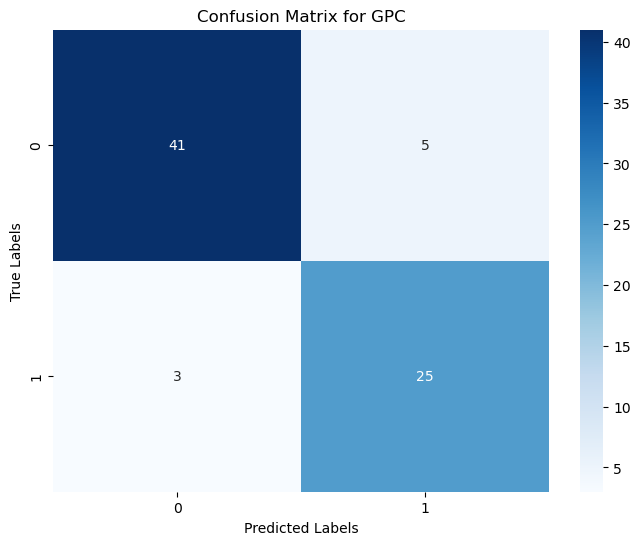

Test accuracy for SVC: 0.878
---------------------------------------------------------------


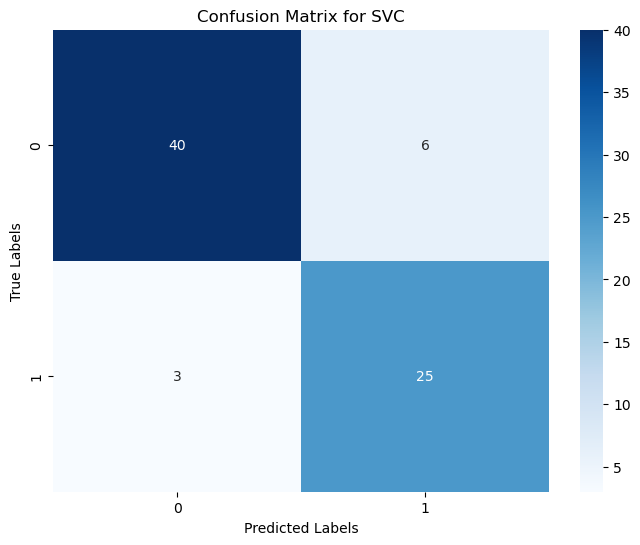

Test accuracy for KNN: 0.865
---------------------------------------------------------------


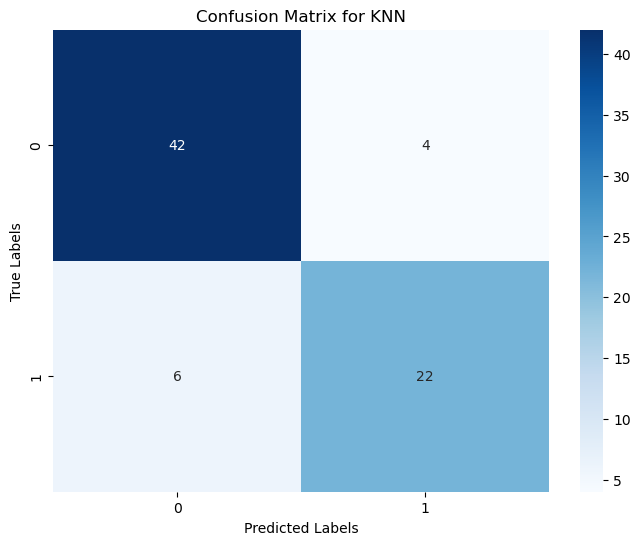

Test accuracy for GNB: 0.865
---------------------------------------------------------------


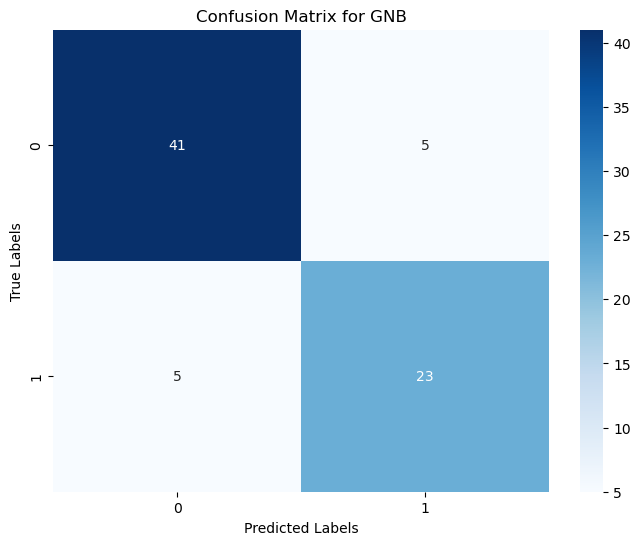

Test accuracy for RFC: 0.865
---------------------------------------------------------------


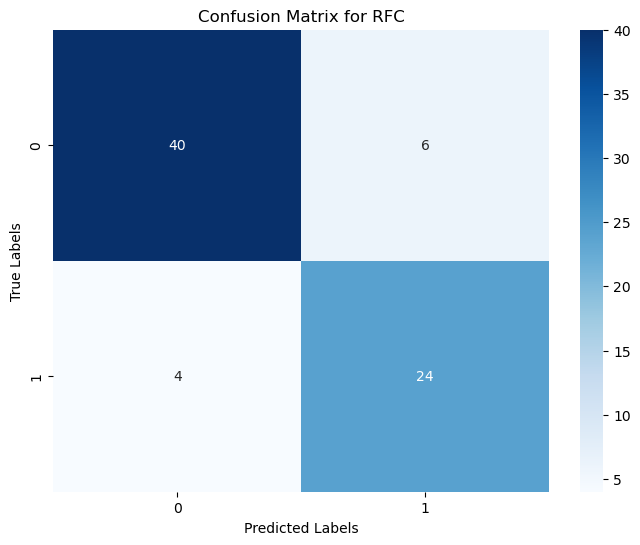

Test accuracy for XGB: 0.838
---------------------------------------------------------------


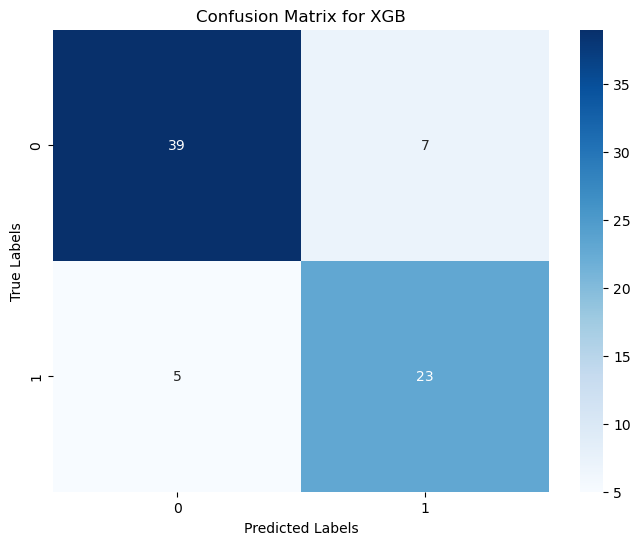

Test accuracy for GBC: 0.865
---------------------------------------------------------------


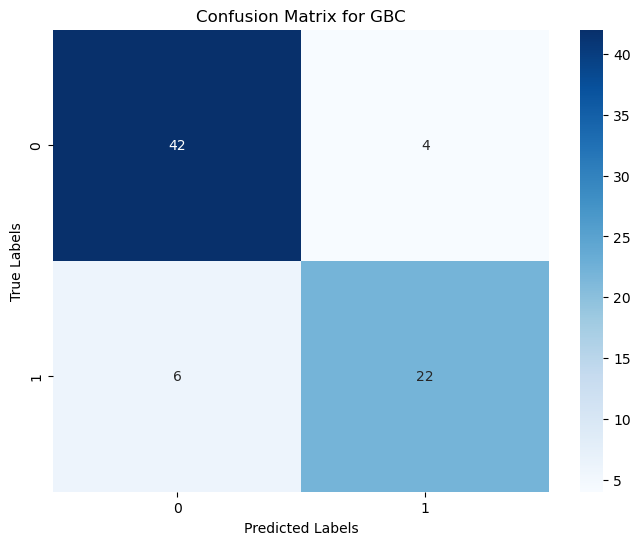

  Model  Test Accuracy
0   GPC       0.891892
1   SVC       0.878378
2   KNN       0.864865
3   GNB       0.864865
4   RFC       0.864865
5   XGB       0.837838
6   GBC       0.864865


In [35]:
names = ["GPC", "SVC", "KNN", "GNB", "RFC", "XGB", "GBC"]
models = get_selected_models(names)
test_predictions(X,y, names, models)

# Lets have some fun with Hyper Parameter Tuning

Best score for XGB: 0.887
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Test accuracy for XGB: 0.865
---------------------------------------------------------------


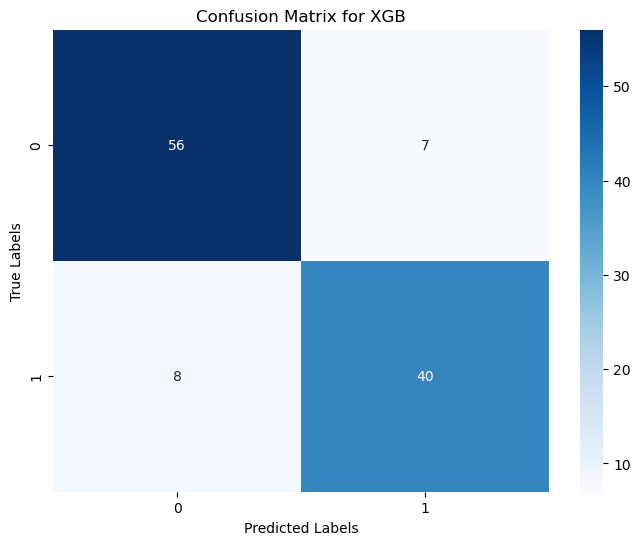

Best score for GBC: 0.890
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 300}
Test accuracy for GBC: 0.856
---------------------------------------------------------------


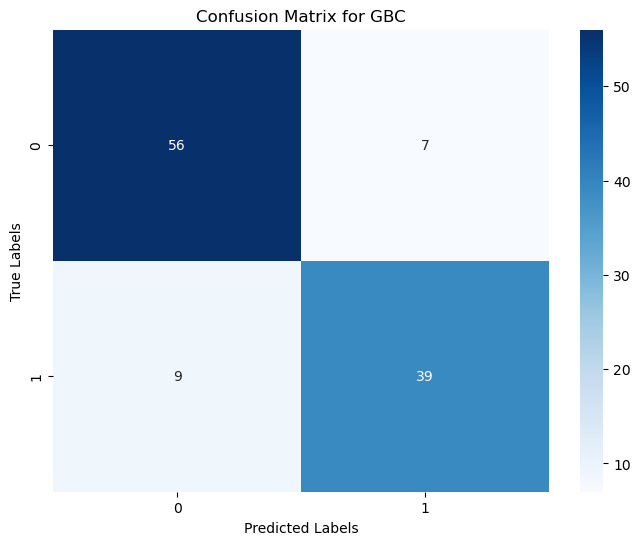

Best score for RFC: 0.914
Best parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Test accuracy for RFC: 0.874
---------------------------------------------------------------


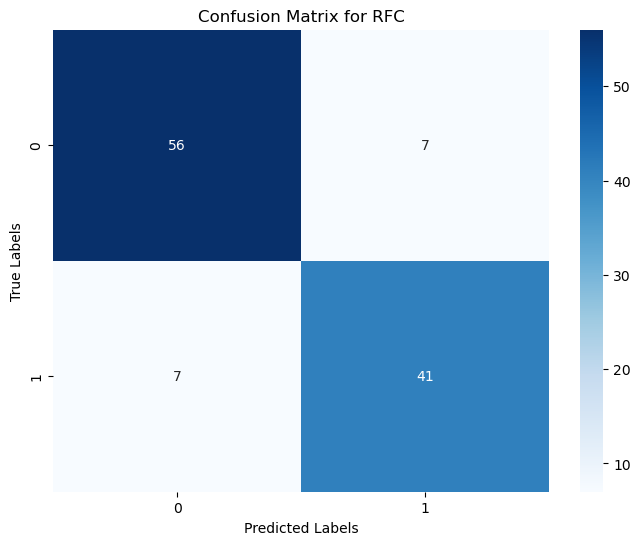

  Model  Best CV Score  Test Accuracy  \
0   XGB       0.886576       0.864865   
1   GBC       0.890498       0.855856   
2   RFC       0.913876       0.873874   

                                     Best Parameters  
0  {'model__learning_rate': 0.1, 'model__max_dept...  
1  {'model__learning_rate': 0.01, 'model__max_dep...  
2  {'model__max_depth': 30, 'model__min_samples_l...  


In [41]:
names = ["XGB", "GBC", "RFC"]
models = get_selected_models(names)

param_grid = {
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

metric = make_scorer(accuracy_score)

grid_search_selected_models(param_grid, names, models, X, y, metric)

# Logistic Regression Hyperparameter Tuning

In [48]:
logistic_regression_tune_cv(X, y)

Best parameters: {'model__C': 0.1, 'model__solver': 'newton-cg'}
Best cross-validation score: 0.848
Test accuracy: 0.829


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('power_transformer',
                                        PowerTransformer()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20,
                                      50, 100, 400],
                         'model__solver': ['newton-cg', 'sag', 'saga',
                                           'lbfgs']},
             scoring='accuracy')

# SVM Hyerparameter Tuning

In [50]:
svm_tune_grid_search(X, y)

Best parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}
Best cross-validation score: 0.894
Test accuracy: 0.883


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('power_transformer',
                                        PowerTransformer()),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')